<a href="https://colab.research.google.com/github/marcehluna/DIIA/blob/main/RAG_GC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DIIAA - RAG en Google Cloud

## Creando tu propio Asistente RAG con Vertex AI

En este cuaderno, aprenderás a construir un sistema completo de **Retrieval-Augmented Generation (RAG)** desde cero. Al final, tendrás un asistente de chat personal que responderá preguntas basándose en un documento PDF que tú mismo subirás.

**Pasos que seguiremos:**
1.  **Autenticación:** Conectaremos este cuaderno a Google Cloud.
2.  **Configuración:** Crearemos un "balde" (Bucket) para guardar tu archivo.
3.  **Carga de Datos:** Subirás un PDF y lo guardaremos en la nube.
4.  **Creación del Cerebro (RAG Engine):** Configuraremos el motor de IA para que lea tu documento.
5.  **Chat:** ¡Haremos preguntas a nuestro nuevo asistente!

In [ ]:
# @title Paso 0: Instalar las librerías necesarias
# Este comando instala en nuestro entorno de Colab las herramientas (SDKs)
# para comunicarnos con los servicios de Google Cloud.
# El `-q` es para que la salida sea más limpia (quiet).
%pip install --upgrade google-cloud-aiplatform google-cloud-storage google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.9 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-aiplatform
    Found existing installation: google-cloud-aiplatform 1.103.0
    Uninstalling google-cloud-aiplatform-1.103.0:
      Successfully uninstalled google-cloud-aiplatform-1.103.0


In [ ]:
# @title Paso 1: Autenticación con Google Cloud
# Para que este cuaderno pueda crear recursos en la nube, necesita permisos.
# Usaremos un archivo de credenciales (JSON) que te ha proporcionado el docente.

import os
from google.colab import files

print("Por favor, sube el archivo JSON de credenciales que te dio el docente.")
# Abre una ventana para que puedas seleccionar y subir el archivo.
uploaded_files = files.upload()

# Verificamos que se subió un archivo y lo configuramos como nuestra credencial.
if uploaded_files:
    key_filename = list(uploaded_files.keys())[0]
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_filename
    print(f"\n✅ ¡Autenticación exitosa con el archivo '{key_filename}'!")
else:
    print("\n⚠️ No se subió ningún archivo. Por favor, ejecuta la celda de nuevo.")

Por favor, sube el archivo JSON de credenciales que te dio el docente.


Saving upgrade-hub-433600-0d9a4265ac14.json to upgrade-hub-433600-0d9a4265ac14.json

✅ ¡Autenticación exitosa con el archivo 'upgrade-hub-433600-0d9a4265ac14.json'!


In [ ]:
# @title Paso 2: Configuración de tu Proyecto
# Completa las siguientes variables con tus datos.

# 1. Proporcionado por el docente:
PROJECT_ID = "upgrade-hub-433600"  # Reemplaza con el ID del proyecto de Google Cloud
LOCATION = "us-central1"               # Reemplaza con la región, ej: "us-central1"

# 2. Tu información:
ID_STUDENT = "mhluna" # Usa tu número de legajo o un identificador único sin espacios

# --- No necesitas modificar nada debajo de esta línea ---
if not PROJECT_ID or "pega-aqui" in PROJECT_ID:
    print("⚠️ ¡Error! Por favor, edita la variable PROJECT_ID con el valor correcto.")
elif not ID_STUDENT or "pega-aqui" in ID_STUDENT:
    print("⚠️ ¡Error! Por favor, edita la variable ID_STUDENT con tu identificador.")
else:
    # Creamos nombres únicos para nuestros recursos
    BUCKET_NAME = "fiuba-01co2025-diiaa"
    RAG_CORPUS_DISPLAY_NAME = f"fiuba-01co2025-diiaa-{ID_STUDENT}"

    print(f"✅ Configuración lista para el proyecto '{PROJECT_ID}' y el alumno '{ID_STUDENT}'.")
    print(f"   - Nombre del Bucket: {BUCKET_NAME}")
    print(f"   - Nombre del RAG Engine: {RAG_CORPUS_DISPLAY_NAME}")

✅ Configuración lista para el proyecto 'upgrade-hub-433600' y el alumno 'mhluna'.
   - Nombre del Bucket: fiuba-01co2025-diiaa
   - Nombre del RAG Engine: fiuba-01co2025-diiaa-mhluna


In [ ]:
# @title Paso 3: Crear el Bucket en Cloud Storage
# Un "bucket" es como una carpeta en la nube donde guardaremos nuestro PDF.
# Este código intentará crear el bucket. Si ya existe, simplemente nos avisará y continuará.

from google.cloud import storage
from google.api_core import exceptions

# Nos aseguramos de que las variables del paso 2 estén definidas
if 'PROJECT_ID' not in locals() or 'BUCKET_NAME' not in locals():
    print("🚨 ¡Error! Por favor, ejecuta la celda del 'Paso 2: Configuración' primero.")
else:
    storage_client = storage.Client(project=PROJECT_ID)

    try:
        print(f"Verificando la existencia del bucket '{BUCKET_NAME}'...")
        bucket = storage_client.create_bucket(BUCKET_NAME, location=LOCATION)
        print(f"✅ Bucket '{bucket.name}' creado exitosamente en la región {LOCATION}.")
    except exceptions.Conflict:
        print(f"✅ El bucket '{BUCKET_NAME}' ya existe. Usando el bucket existente.")
    except Exception as e:
        print(f"🚨 Ocurrió un error inesperado al interactuar con el bucket: {e}")

Verificando la existencia del bucket 'fiuba-01co2025-diiaa'...
✅ El bucket 'fiuba-01co2025-diiaa' ya existe. Usando el bucket existente.


In [ ]:
# @title Paso 4: Sube tu PDF y lo guardamos en el Bucket
# Este paso sube tu PDF al entorno de Colab y luego lo copia a nuestro bucket en la nube.
# Se ha añadido una verificación para no volver a subir el archivo si ya existe en el bucket.

from google.cloud import storage

# Nos aseguramos de que las variables necesarias existan
if 'storage_client' not in locals() or 'BUCKET_NAME' not in locals() or 'ID_STUDENT' not in locals():
    print("🚨 ¡Error! Por favor, ejecuta las celdas anteriores primero.")
else:
    # Primero, sube el archivo PDF a este entorno de Colab.
    print("Por favor, sube el archivo PDF con el que quieres chatear.")
    uploaded_pdf = files.upload()

    if uploaded_pdf:
        local_pdf_path = list(uploaded_pdf.keys())[0]

        # Le damos un nombre único al archivo en el bucket para evitar conflictos
        blob_name = f"{ID_STUDENT}-{local_pdf_path}"

        bucket = storage_client.bucket(BUCKET_NAME)
        blob = bucket.blob(blob_name)

        # --- VERIFICACIÓN DE EXISTENCIA ---
        if blob.exists():
            print(f"\n✅ El archivo '{blob_name}' ya existe en el bucket. Saltando la subida.")
        else:
            print(f"\nSubiendo '{local_pdf_path}' a gs://{BUCKET_NAME}/{blob_name}...")
            blob.upload_from_filename(local_pdf_path)
            print(f"✅ ¡Archivo subido exitosamente!")

        # Guardamos la ruta completa del archivo en la nube (URI) para el siguiente paso
        GCS_PDF_URI = f"gs://{BUCKET_NAME}/{blob_name}"
        print(f"   URI del archivo a utilizar: {GCS_PDF_URI}")
    else:
        print("\n⚠️ No se subió ningún archivo. Por favor, ejecuta la celda de nuevo.")

Por favor, sube el archivo PDF con el que quieres chatear.


Saving toaz.info-timonel-de-vela-facil-pr_d98457863a98d0b8cc604908401cc7b0.pdf to toaz.info-timonel-de-vela-facil-pr_d98457863a98d0b8cc604908401cc7b0.pdf

✅ El archivo 'mhluna-toaz.info-timonel-de-vela-facil-pr_d98457863a98d0b8cc604908401cc7b0.pdf' ya existe en el bucket. Saltando la subida.
   URI del archivo a utilizar: gs://fiuba-01co2025-diiaa/mhluna-toaz.info-timonel-de-vela-facil-pr_d98457863a98d0b8cc604908401cc7b0.pdf


In [ ]:
# @title Paso 5: Crear o encontrar tu RAG Engine
# Este paso busca un RAG Engine (Corpus) que te pertenezca.
# - Si lo encuentra, lo usará directamente.
# - Si no lo encuentra, creará uno nuevo e importará tu PDF.
# Esto evita crear duplicados si ejecutas el cuaderno varias veces.

import vertexai
from vertexai.preview import rag
import time

# Nos aseguramos de que las variables necesarias existan
if 'PROJECT_ID' not in locals() or 'LOCATION' not in locals() or 'RAG_CORPUS_DISPLAY_NAME' not in locals():
    print("🚨 ¡Error! Por favor, ejecuta las celdas anteriores primero.")
else:
    # Inicializamos el SDK de Vertex AI
    vertexai.init(project=PROJECT_ID, location=LOCATION)

    # --- VERIFICACIÓN DE EXISTENCIA ---
    print(f"Buscando un RAG Corpus existente con el nombre: '{RAG_CORPUS_DISPLAY_NAME}'...")

    rag_corpora = rag.list_corpora()
    found_corpus = None
    for corpus in rag_corpora:
        if corpus.display_name == RAG_CORPUS_DISPLAY_NAME:
            found_corpus = corpus
            break # Salimos del bucle en cuanto lo encontramos

    # Si encontramos un corpus, usamos ese. Si no, creamos uno nuevo.
    if found_corpus:
        rag_corpus = found_corpus
        print(f"✅ Corpus encontrado. Usando el corpus existente con ID: {rag_corpus.name}")
    else:
        print(f"No se encontró un corpus existente. Creando uno nuevo...")
        # Creamos el Corpus
        rag_corpus = rag.create_corpus(display_name=RAG_CORPUS_DISPLAY_NAME)
        print(f"✅ Corpus creado con el ID: {rag_corpus.name}")

        print(f"\nImportando tu PDF ({GCS_PDF_URI}) al nuevo corpus...")
        # Importamos el archivo desde el bucket al corpus
        # Esta operación solo se realiza cuando el corpus es nuevo.
        rag.import_files(
            rag_corpus.name,
            [GCS_PDF_URI],
            chunk_size=1024,
            chunk_overlap=100
        )
        print("\n\n✅ ¡Proceso de importación iniciado!")
        print("¡ATENCIÓN! La indexación del archivo puede tardar varios minutos.")

    # Guardamos el nombre del recurso para usarlo en el chat
    RAG_CORPUS_RESOURCE_NAME = rag_corpus.name
    print(f"\nListo para usar el RAG Engine con el recurso: {RAG_CORPUS_RESOURCE_NAME}")
    print("Puedes continuar a la siguiente celda, pero si el chat da error, espera un poco y vuelve a intentarlo.")

Buscando un RAG Corpus existente con el nombre: 'fiuba-01co2025-diiaa-mhluna'...
✅ Corpus encontrado. Usando el corpus existente con ID: projects/upgrade-hub-433600/locations/us-central1/ragCorpora/2443202797848494080

Listo para usar el RAG Engine con el recurso: projects/upgrade-hub-433600/locations/us-central1/ragCorpora/2443202797848494080
Puedes continuar a la siguiente celda, pero si el chat da error, espera un poco y vuelve a intentarlo.


In [ ]:
# @title Paso 6: Inicializamos el asistente virtual

import vertexai
from vertexai import rag
from vertexai.generative_models import GenerativeModel, Tool, GenerationConfig, HarmCategory, HarmBlockThreshold

# --- 1. Inicialización de Vertex AI ---
# Como en la documentación, inicializamos el SDK.
print("Inicializando el SDK de Vertex AI...")
vertexai.init(project=PROJECT_ID, location=LOCATION)
print("✅ SDK de Vertex AI inicializado.")

# --- 2. Creación de la Herramienta RAG ---
# Utilizamos el patrón exacto de la documentación que proporcionaste.
# La clave es usar `rag.VertexRagStore`.
print("Creando la herramienta de recuperación (RAG) con 'VertexRagStore'...")
rag_tool = Tool.from_retrieval(
    retrieval=rag.Retrieval(
        source=rag.VertexRagStore(
            rag_resources=[
                rag.RagResource(
                    rag_corpus=RAG_CORPUS_RESOURCE_NAME,
                )
            ]
        ),
    )
)
print("✅ Herramienta RAG creada exitosamente.")

# --- 3. Configuración del Modelo Generativo ---
# Instanciamos el modelo y le pasamos la herramienta RAG.
print("Configurando el modelo GenerativeModel...")
# Usamos un modelo compatible con herramientas. gemini-1.5-pro es una excelente opción.
model = GenerativeModel(
    model_name="gemini-2.5-flash",
    tools=[rag_tool] # Conectamos la herramienta al modelo.
)
print("✅ Modelo configurado con la herramienta RAG.")

# --- 4. Generamos respuesta ---
query = input("Introduce tu pregunta: ")
response = model.generate_content(
  contents=query,
  generation_config=GenerationConfig(
    temperature=0.6,
    top_p=0.95,
    top_k=40,
    candidate_count=1,
    max_output_tokens=8192,
    #stop_sequences=["STOP!"],
    response_logprobs=False,
    #logprobs=3,
  ),
  safety_settings={
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
  },
)

print(f"Respuesta: {response.candidates[0].to_dict()['content']['parts'][0]['text']}")

/usr/local/lib/python3.11/dist-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


Inicializando el SDK de Vertex AI...
✅ SDK de Vertex AI inicializado.
Creando la herramienta de recuperación (RAG) con 'VertexRagStore'...
✅ Herramienta RAG creada exitosamente.
Configurando el modelo GenerativeModel...
✅ Modelo configurado con la herramienta RAG.
Introduce tu pregunta: Que barcos puede navegar un timonel?
Respuesta: Un timonel de yate puede gobernar embarcaciones deportivas de hasta veinte metros de eslora, ya sean a vela, a motor o a vela y motor.

Pueden navegar en:
*   Lagos y ríos interiores en toda su extensión.
*   El Río de la Plata, en la zona al oeste de la línea imaginaria que une Punta Atalaya (Argentina) con Punta Rosario (Uruguay).
*   En zonas marítimas, en los lugares que establezca la dependencia de Prefectura.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Ejercicios (personas con experiencia en código)

A continuación, para las personas con más conocimiento del lengauje de programación, sugerimos los siguientes ejercicios:

## Ejercicio 1: Generación de un dataset de preguntas para el sistema RAG

**Objetivo**: Crear un fichero de preguntas de alta calidad en formato JSONL para evaluar de forma sistemática el conocimiento de vuestro sistema sobre el PDF.

**¿Por qué es importante?**: Un buen sistema de evaluación empieza con buenas preguntas. Si solo hacemos preguntas fáciles o sobre un único tema del documento, no tendremos una idea real de sus capacidades y limitaciones. Necesitamos un conjunto de preguntas diverso que cubra el documento en su totalidad.

**Pasos a seguir:**
1. Relee tu PDF con ojo crítico: Piensa como si fueras un examinador. ¿Qué tipo de preguntas harías para saber si alguien ha entendido el documento a fondo?
  * Preguntas de extracción directa: "¿Cuál es la fecha de publicación del documento?" o "¿Qué es el "Modelo X" según la sección 3?".
  * Preguntas de resumen: "Resume los puntos clave del capítulo 2" o "¿Cuáles son las principales conclusiones del estudio?".
  * Preguntas de comparación: "Compara las metodologías A y B descritas en el apéndice".
  * Preguntas "difíciles": Preguntas sobre detalles pequeños, notas a pie de página o que requieran conectar información de distintas secciones.
  * Preguntas fuera de dominio: Formula alguna pregunta que sabes que no está en el documento. La respuesta ideal del sistema debería ser algo como "No tengo información sobre eso en el documento proporcionado".

2. Crea el fichero JSONL: JSONL (JSON Lines) es un formato de texto donde cada línea es un objeto JSON válido. Es muy práctico para procesar grandes datasets. Tu fichero, que podrías llamar preguntas_evaluacion.jsonl, tendrá este aspecto:

```json
{"unique_id": "pregunta_001", "query": "¿Cuál es el objetivo principal del documento?"}
{"unique_id": "pregunta_002", "query": "Resume en tres puntos la sección sobre 'Resultados Preliminares'."}
{"unique_id": "pregunta_003", "query": "¿Qué autor se cita en la página 5 en relación con la metodología?"}
...
{"unique_id": "pregunta_050", "query": "¿Cuál es la predicción del tiempo para mañana?"}
```

  * unique_id: Un identificador único para cada pregunta. Te será muy útil para rastrear los resultados.
  * query: La pregunta que has formulado.

**Pista de código:** Puedes crear este archivo manualmente o usar un pequeño script de Python para ayudarte a generarlo.

```python
import json

# Lista de preguntas que has formulado
preguntas = [
    "¿Cuál es el objetivo principal del documento?",
    "Resume en tres puntos la sección sobre 'Resultados Preliminares'.",
    "¿Qué autor se cita en la página 5 en relación con la metodología?",
    # ... añade aquí entre 30 y 50 preguntas
]

# Nombre del archivo de salida
nombre_archivo = "queries_rag.jsonl"

with open(nombre_archivo, "w", encoding="utf-8") as f:
    for i, pregunta in enumerate(preguntas):
        # Creamos el diccionario para cada pregunta
        record = {
            "unique_id": f"pregunta_{i+1:03d}", # 'pregunta_001', 'pregunta_002', etc.
            "query": pregunta
        }
        # Escribimos el objeto JSON como una línea en el archivo
        f.write(json.dumps(record, ensure_ascii=False) + "\n")

print(f"✅ ¡Archivo '{nombre_archivo}' generado con {len(preguntas)} preguntas!")
```

In [ ]:
#  Mi código para la generación del archivo con preguntas - ML

import json

# Lista de preguntas que has formulado
preguntas = [
    "1. ¿Cuál es el título completo del manual y quién es su autor principal?",
    "2. Según el manual, ¿cuántos metros mide una milla marina?",
    "3. ¿Qué significa 'cazar' una escota en el contexto de las maniobras a vela?",
    "4. ¿Qué instrumento se utiliza para medir la presión atmosférica?",
    "5. ¿Qué nombre reciben los listones que arman la baluma de las velas?",
    "6. ¿Cuál es el canal de llamada y para emergencias por convención internacional en las radiocomunicaciones VHF?",
    "7. ¿Qué es la pleamar?",
    "8. Según el RIPPA, ¿qué significa específicamente la palabra 'abordaje'?",
    "9. ¿Cuál es el número de teléfono directo de Prefectura Naval Argentina para urgencias?",
    "10. ¿Cuál es el nombre de la publicación del Servicio de Hidrografía Naval (SHN) que contiene el elenco de todas las cartas náuticas editadas?",
    "11. Resuma las precauciones de seguridad esenciales que deben tomarse al cargar combustible en una embarcación.",
    "12. Describa brevemente los pasos principales para realizar la maniobra de 'hombre al agua' a vela, según el manual.",
    "13. Explique el concepto de 'equilibrio vélico' y qué indica si un barco tira mucho a orzar.",
    "14. Sintetice qué información esencial proveen las cartas náuticas, además de los contornos de la costa.",
    "15. Resuma las 'cinco reglas de oro' para navegar con viento fuerte o temporal inminente, según el manual.",
    "16. Describa el procedimiento para envergar un foque o velas de estay en general.",
    "17. Sintetice qué es el balizamiento y sus componentes principales.",
    "18. Resuma las características principales de una 'sudestada' en el Río de la Plata, incluyendo su origen y duración.",
    "19. Describa el régimen operativo de descarga de basura en navegación marítima, diferenciando lo permitido a 3, 12 y 25 millas de la costa.",
    "20. ¿Cuáles son las cinco condiciones esenciales de una embarcación que las averías pueden comprometer, y por qué son importantes?",
    "21. Compare las diferencias entre la 'virada por avante' y la 'virada en redondo', indicando en qué dirección gira el barco en cada caso.",
    "22. Diferencie un 'yawl' de un 'queche' en cuanto a la altura y ubicación de su palo mesana.",
    "23. Compare los principales usos de los cabos de Dacron, Nylon y polietileno/polipropileno, destacando una propiedad clave de cada uno.",
    "24. Explique la diferencia entre 'correr el temporal' y 'capear' el temporal como estrategias de navegación con mal tiempo.",
    "25. Compare los tipos de anclas Danforth y arado (CQR/Delta) en términos de sus características de agarre y facilidad de estiba en la proa del barco.",
    "26. Diferencie las 'mareas vivas o de sicigias' de las 'mareas muertas o de cuadratura', indicando cuándo se producen y su amplitud.",
    "27. Compare la navegación con viento de popa redonda y la navegación con viento de través en cuanto a la posición ideal de la vela mayor y el foque.",
    "28. ¿Cuál es la diferencia principal entre un motor naftero y un motor diésel para veleros en términos de combustible y mecanismo de combustión?",
    "29. Compare las características y duración de un 'pampero' y una 'sudestada' en el Río de la Plata.",
    "30. Diferencie la 'luz de tope' de las 'luces de costado' de una embarcación en navegación nocturna, en cuanto a su color y el arco de visibilidad que cubren.",
    "31. Al navegar de ceñida, ¿por qué es crucial que el timonel observe la parte del foque contra el estay y la mayor contra el palo, y qué acción debe tomar si la vela 'se pincha'?",
    "32. Explique por qué, para un barco de la misma eslora, un aparejo tipo 'cutter' o 'queche' podría ser más fácil de manipular para la tripulación que un 'sloop'.",
    "33. ¿Qué implicaciones tiene el efecto de 'rabeo' de la hélice en la maniobra de un velero con motor, especialmente al tomar arrancada o en aceleraciones bruscas, y cómo puede mitigar su efecto en cruceros o lanchas con dos motores?",
    "34. Si un barco se vara sobre fondo blando y el agua profunda queda a sotavento, ¿cuál es la secuencia de maniobras a realizar para intentar zafar, y por qué el uso del tangón puede ser fundamental en esta situación?",
    "35. El manual enfatiza la 'paciencia' como una 'virtud cardinal del marino' en visibilidad reducida. Más allá de las precauciones técnicas, ¿qué actitud y decisiones se espera de un timonel prudente en estas condiciones?",
    "36. ¿Por qué el manual desaconseja el uso de bebidas alcohólicas a una persona que sufre hipotermia severa, a pesar de que podría parecer que calientan el cuerpo?",
    "37. Explique cómo la acción meteorológica, específicamente la dirección y fuerza del viento, puede causar una diferencia significativa entre la marea predicha y la observada en el Río de la Plata, y cómo puede un navegante obtener información actualizada sobre estas correcciones.",
    "38. En una emergencia de 'hombre al agua' con viento fuerte, el manual especifica subir a la persona por la banda de sotavento. Explique la lógica detrás de esta decisión y los peligros que se evitan.",
    "39. Si un navegante no depende exclusivamente de la señal GPS para situarse, ¿qué otros métodos de navegación costera le permitirían determinar su posición, y qué precaución se debe tener con la 'intersección de líneas' para asegurar la fiabilidad?",
    "40. Al fondear, ¿por qué es importante no largar toda la cadena junta sobre el ancla y controlar su caída 'a medida que el barco retrocede y va pidiendo cadena'?",
    "41. ¿Cuál es el costo aproximado de la matrícula anual para un velero de 10 toneladas en Argentina?",
    "42. ¿Cuál es la distancia en millas náuticas entre Buenos Aires y Mar del Plata?",
    "43. ¿Qué tipo de extintor de incendios es el más recomendado para veleros deportivos?",
    "44. ¿Cuál es la profundidad promedio del Río de la Plata en su desembocadura, más allá de la máxima de 25m?",
    "45. ¿Qué materiales son los más ecológicos para la construcción de cascos de veleros?",
    "46. ¿Cuántos tripulantes se recomiendan para un velero de 15 metros de eslora con aparejo de sloop?",
    "47. ¿Qué tipo de fauna marina es característica del Río de la Plata que pueda afectar la navegación?",
    "48. ¿Cuál es la cantidad ideal de aceite lubricante para un motor diésel de 30 HP?",
    "49. ¿Cuál es la altitud de la ciudad de Buenos Aires sobre el nivel del mar?",
    "50. ¿Cuáles son las regulaciones sobre el uso de drones para fotografía aérea en el Río de la Plata?",
]

# Nombre del archivo de salida
nombre_archivo = "queries_rag.jsonl"

with open(nombre_archivo, "w", encoding="utf-8") as f:
    for i, pregunta in enumerate(preguntas):
        # Creamos el diccionario para cada pregunta
        record = {
            "unique_id": f"pregunta_{i+1:03d}", # 'pregunta_001', 'pregunta_002', etc.
            "query": pregunta
        }
        # Escribimos el objeto JSON como una línea en el archivo
        f.write(json.dumps(record, ensure_ascii=False) + "\n")

print(f"✅ ¡Archivo '{nombre_archivo}' generado con {len(preguntas)} preguntas!")

✅ ¡Archivo 'queries_rag.jsonl' generado con 50 preguntas!


## Ejercicio 2: Generación de respuestas con un script automatizado

**Objetivo:** Convertir la lógica del notebook en un script de Python reutilizable que lea tu fichero de preguntas y genere todas las respuestas de forma automática, aceptando parámetros desde la línea de comandos.

**¿Por qué usar un script y la librería fire?**
  * Automatización: Es la única forma viable de procesar decenas o cientos de preguntas.
  * Reusabilidad: Puedes usar el mismo script para diferentes modelos, documentos o parámetros.
  * `fire`: Esta librería de Google convierte automáticamente cualquier función de Python en una interfaz de línea de comandos (CLI). Es increíblemente sencilla y potente. En lugar de tener que modificar el código para cambiar la temperatura, simplemente la pasas como un argumento: `python mi_script.py --temperature 0.8`

**Pasos a seguir:**
  1. Instalar `fire`:
  ```python
  python -m pip install fire
  ```
  2. Estructura tu script (`answers_rag.py`): El script debe encapsular la lógica que ya tenías en el notebook. La estructura ideal sería:
    * Importar las librerías necesarias (fire, json, vertexai, etc.).
    * Definir una función principal (p. ej., generar_evaluacion) que acepte como argumentos los parámetros que quieres poder configurar (el fichero de entrada, el de salida, el modelo a usar, la temperatura, top_p, top_k, etc.).
    * Dentro de esta función:
      * Inicializar Vertex AI.
      * Crear la herramienta RAG (necesitarás el RAG_CORPUS_RESOURCE_NAME que obtuviste en el notebook).
      * Configurar el modelo generativo con los parámetros recibidos.
      * Abrir el archivo de preguntas y el de salida.
      * Iterar línea por línea sobre las preguntas.
      * Para cada pregunta, llamar a model.generate_content().
      * Crear un nuevo diccionario JSON que contenga la información original (`unique_id`, `query`) más los nuevos datos (`answer`, `llm_model`, `temperature`, `top_p`, `top_k`, `max_output_tokens`).
      * Guardar este nuevo diccionario en el fichero JSONL de resultados.
    * Al final del script, añadir el código para que `fire` exponga tu función.

**Pista de código:**

```python
import fire
import json
import vertexai
from vertexai.preview import rag
from vertexai.generative_models import GenerativeModel, Tool, GenerationConfig
import time

# --- Pega aquí las constantes de tu proyecto ---
PROJECT_ID = "upgrade-hub-433600"
LOCATION = "us-central1"
# ¡MUY IMPORTANTE! Pega aquí el nombre del recurso que obtuviste en el paso 5 del notebook.
RAG_CORPUS_RESOURCE_NAME = "projects/1044524817197/locations/us-central1/ragCorpora/2443202797848494080" # YA ACTUALIZADO CON MI RECURSO


def generar_evaluacion(
    input_file: str = "queries_rag.jsonl",
    output_file: str = "answers_rag.jsonl",
    model_name: str = "gemini-2.5-flash",
    temperature: float = 0.6,
    top_p: float = 0.95,
    top_k: int = 40,
    max_output_tokens: int = 1024
):
    """
    Genera respuestas para un conjunto de preguntas usando un sistema RAG
    y guarda los resultados en un fichero JSONL.
    """
    print("--- Iniciando el proceso de generación de respuestas ---")
    print(f"Usando el modelo: {model_name} con temperatura={temperature}")

    # 1. Inicialización de Vertex AI
    vertexai.init(project=PROJECT_ID, location=LOCATION)

    # 2. Creación de la Herramienta RAG
    rag_tool = Tool.from_retrieval(
        retrieval=rag.Retrieval(
            source=rag.VertexRagStore(
                rag_resources=[rag.RagResource(rag_corpus=RAG_CORPUS_RESOURCE_NAME)]
            )
        )
    )

    # 3. Configuración del Modelo Generativo
    model = GenerativeModel(model_name=model_name, tools=[rag_tool])

    generation_params = {
        "temperature": temperature,
        "top_p": top_p,
        "top_k": top_k,
        "max_output_tokens": max_output_tokens,
    }
    generation_config = GenerationConfig(**generation_params)

    # 4. Procesamiento de archivos
    print(f"Leyendo preguntas de: {input_file}")
    with open(input_file, "r", encoding="utf-8") as f_in, \
         open(output_file, "w", encoding="utf-8") as f_out:

        for line in f_in:
            pregunta_data = json.loads(line)
            query = pregunta_data["query"]
            print(f"Generando respuesta para ID: {pregunta_data['unique_id']}...")

            # 5. Generar respuesta
            response = model.generate_content(
                contents=query,
                generation_config=generation_config
            )

            # 6. Guardar resultados
            resultado = {
                "unique_id": pregunta_data["unique_id"],
                "query": query,
                "answer": response.text,
                "llm_model": model_name,
                "temperature": generation_params.temperature,
                "top_p": generation_params.top_p,
                "top_k": generation_params.top_k,
                "max_output_tokens": generation_params.max_output_tokens,
            }
            f_out.write(json.dumps(resultado, ensure_ascii=False) + "\n")

            # Pequeña pausa para no sobrecargar las APIs
            time.sleep(1)

    print(f"--- Proceso completado. Resultados guardados en '{output_file}' ---")


if __name__ == '__main__':
    fire.Fire(generar_evaluacion)
```

In [ ]:
!python -m pip install fire

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=a3b5a34818a3fa56e5d428640172eb4da7740c4b40c6c2ab3e701e4e039a3955
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [ ]:
import fire
import json
import vertexai
from vertexai.preview import rag
from vertexai.generative_models import GenerativeModel, Tool, GenerationConfig
import time
import sys # Import the sys module
import os # Import the os module

# --- Pega aquí las constantes de tu proyecto ---
PROJECT_ID = "upgrade-hub-433600"
LOCATION = "us-central1"
# ¡MUY IMPORTANTE! Pega aquí el nombre del recurso que obtuviste en el paso 5 del notebook.
# Make sure to use the correct RAG_CORPUS_RESOURCE_NAME from your successful run of cell fC5sle0Bib6e
RAG_CORPUS_RESOURCE_NAME = "projects/upgrade-hub-433600/locations/us-central1/ragCorpora/2443202797848494080"


def generar_evaluacion(
    input_file: str = "queries_rag.jsonl",
    output_file: str = "answers_rag.jsonl",
    model_name: str = "gemini-2.5-flash",
    temperature: float = 0.6,   #Jugar con este parametro a ver que pasa con las preguntas generadas y como las evalua el juez
    top_p: float = 0.95,
    top_k: int = 40,
    max_output_tokens: int = 1024
):
    """
    Genera respuestas para un conjunto de preguntas usando un sistema RAG
    y guarda los resultados en un fichero JSONL.
    """
    print("--- Iniciando el proceso de generación de respuestas ---")
    print(f"Usando el modelo: {model_name} con temperature={temperature}")
    print(f"Reading questions from: {input_file}") # Print the input file path

    # Check if input file exists and is not empty
    if not os.path.exists(input_file):
        print(f"🚨 Error: Input file '{input_file}' not found.")
        return
    if os.path.getsize(input_file) == 0:
        print(f"🚨 Error: Input file '{input_file}' is empty.")
        return

    # 1. Inicialización de Vertex AI
    vertexai.init(project=PROJECT_ID, location=LOCATION)

    # 2. Creación de la Herramienta RAG
    rag_tool = Tool.from_retrieval(
        retrieval=rag.Retrieval(
            source=rag.VertexRagStore(
                rag_resources=[rag.RagResource(rag_corpus=RAG_CORPUS_RESOURCE_NAME)]
            )
        )
    )

    # 3. Configuración del Modelo Generativo
    model = GenerativeModel(model_name=model_name, tools=[rag_tool])

    generation_params = {
        "temperature": temperature,
        "top_p": top_p,
        "top_k": top_k,
        "max_output_tokens": max_output_tokens,
    }
    generation_config = GenerationConfig(**generation_params)

    # 4. Processing files
    with open(input_file, "r", encoding="utf-8") as f_in, \
         open(output_file, "w", encoding="utf-8") as f_out:

        for line in f_in:
            try:
                pregunta_data = json.loads(line)
                query = pregunta_data.get("query")
                unique_id = pregunta_data.get("unique_id")

                if not query:
                    print(f"  -> Warning: Skipping line with missing 'query' key: {line.strip()}")
                    continue
                if not unique_id:
                     print(f"  -> Warning: Processing line with missing 'unique_id' key: {line.strip()}")
                     unique_id = "unknown_id" # Assign a default if missing


                print(f"Generating response for ID: {unique_id}...")

                # 5. Generate response
                response = model.generate_content(
                    contents=query,
                    generation_config=generation_config
                )

                # 6. Save results
                resultado = {
                    "unique_id": unique_id,
                    "query": query,
                    "answer": response.text,
                    "llm_model": model_name,
                    "temperature": generation_params["temperature"],
                    "top_p": generation_params["top_p"],
                    "top_k": generation_params["top_k"],
                    "max_output_tokens": generation_params["max_output_tokens"],
                }
                f_out.write(json.dumps(resultado, ensure_ascii=False) + "\n")

                # Small pause to avoid overloading APIs
                time.sleep(1)

            except json.JSONDecodeError as e:
                print(f"  -> Error decoding JSON line: {line.strip()} - {e}")
                # Optionally write an error record to the output file
                error_record = {"error": "JSONDecodeError", "line": line.strip(), "message": str(e)}
                f_out.write(json.dumps(error_record, ensure_ascii=False) + "\n")
            except Exception as e:
                print(f"  -> An unexpected error occurred while processing line: {line.strip()} - {e}")
                # Optionally write an error record to the output file
                error_record = {"error": "ProcessingError", "line": line.strip(), "message": str(e)}
                f_out.write(json.dumps(error_record, ensure_ascii=False) + "\n")


    print(f"--- Process completed. Results saved to '{output_file}' ---")


if __name__ == '__main__':
    # This line checks if the script is being run in a Colab environment
    # and passes an empty list of arguments to fire.Fire() if it is,
    # preventing the "FireExit: 2" error.
    if 'google.colab' in sys.modules:
        fire.Fire(generar_evaluacion, []) # Pass an empty list of arguments
    else:
        fire.Fire(generar_evaluacion)

--- Iniciando el proceso de generación de respuestas ---
Usando el modelo: gemini-2.5-flash con temperature=0.6
Reading questions from: queries_rag.jsonl
Generating response for ID: pregunta_001...
Generating response for ID: pregunta_002...
Generating response for ID: pregunta_003...
Generating response for ID: pregunta_004...
Generating response for ID: pregunta_005...
Generating response for ID: pregunta_006...
Generating response for ID: pregunta_007...
Generating response for ID: pregunta_008...
Generating response for ID: pregunta_009...
Generating response for ID: pregunta_010...
Generating response for ID: pregunta_011...
Generating response for ID: pregunta_012...
Generating response for ID: pregunta_013...
Generating response for ID: pregunta_014...
  -> An unexpected error occurred while processing line: {"unique_id": "pregunta_014", "query": "14. Sintetice qué información esencial proveen las cartas náuticas, además de los contornos de la costa."} - Cannot get the response 

## Ejercicio 3: LLM as a Judge

**Objetivo:** Utilizar un modelo de lenguaje de última generación (como Gemini 2.5 Pro) para evaluar la calidad de las respuestas generadas por tu sistema RAG, guardando las puntuaciones y justificaciones.

**¿Por qué es esto tan potente?**: Evaluar manualmente 50 respuestas es lento y subjetivo. Un LLM avanzado puede hacerlo de forma rápida, consistente y siguiendo criterios específicos que le demos. Esta técnica nos permite escalar la evaluación de nuestros sistemas de IA.

**Pasos a seguir:**

1.  **Diseña el "Prompt del Juez":** Este es el paso más importante. Debes crear un prompt que le dé instrucciones claras al LLM sobre cómo debe evaluar cada par de pregunta-respuesta. Un buen prompt es un arte, pero aquí tienes una plantilla robusta.

  **Plantilla de Prompt para el Juez:**

```text
Eres un evaluador experto y meticuloso de sistemas de Pregunta-Respuesta (Q&A). Tu tarea es evaluar la calidad de una respuesta generada por un sistema de IA, basándote únicamente en una pregunta dada.

**Pregunta Original:**
{query}

**Respuesta Generada por la IA:**
{answer}

**Tus Criterios de Evaluación son:**
1.  **Relevancia y Coherencia:** ¿La respuesta aborda directamente la pregunta formulada? ¿Es coherente y fácil de entender?
2.  **Corrección y Fidelidad (si aplica):** Aunque no tienes acceso al documento original, evalúa si la respuesta parece factualmente plausible y si no contiene contradicciones obvias. Penaliza las respuestas que especulan o inventan información. Si la respuesta admite no saber la respuesta, considéralo positivo.

**Tu Tarea:**
Proporciona una evaluación en el siguiente formato JSON. No añadas nada antes o después del objeto JSON.

{{
  "puntuacion_relevancia": [Un número entero del 1 al 5, donde 1 es "totalmente irrelevante" y 5 es "perfectamente relevante y directa"],
  "justificacion": "[Una explicación clara y concisa (1-2 frases) que justifique tu puntuación, explicando los puntos fuertes y débiles de la respuesta.]"
}}
```

2.  **Crea el script `llm_as_a_judge.py`:**
    Este script será muy similar al anterior. Usará `fire`, leerá el fichero de resultados del ejercicio 2, y para cada resultado, llenará la plantilla del prompt y llamará a la API de Gemini 2.5 Pro.

**Código de ejemplo (`llm_as_a_judge.py`):** A continuación brindamos una sugerencia de código:

```python

import fire
import json
import vertexai
from vertexai.generative_models import GenerativeModel, GenerationConfig
import time

# --- Pega aquí las constantes de tu proyecto ---
PROJECT_ID = "upgrade-hub-433600"
LOCATION = "us-central1"

# El prompt que hemos diseñado
JUDGE_PROMPT_TEMPLATE = """
Eres un evaluador experto y meticuloso de sistemas de Pregunta-Respuesta (Q&A). Tu tarea es evaluar la calidad de una respuesta generada por un sistema de IA, basándote únicamente en una pregunta dada.

**Pregunta Original:**
{query}

**Respuesta Generada por la IA:**
{answer}

**Tus Criterios de Evaluación son:**
1.  **Relevancia y Coherencia:** ¿La respuesta aborda directamente la pregunta formulada? ¿Es coherente y fácil de entender?
2.  **Corrección y Fidelidad (si aplica):** Aunque no tienes acceso al documento original, evalúa si la respuesta parece factualmente plausible y si no contiene contradicciones obvias. Penaliza las respuestas que especulan o inventan información. Si la respuesta admite no saber la respuesta, considéralo positivo.

**Tu Tarea:**
Proporciona una evaluación en el siguiente formato JSON. No añadas nada antes o después del objeto JSON.

{{
  "puntuacion_relevancia": "[Un número entero del 1 al 5, donde 1 es 'totalmente irrelevante' y 5 es 'perfectamente relevante y directa']",
  "justificacion": "[Una explicación clara y concisa (1-2 frases) que justifique tu puntuación, explicando los puntos fuertes y débiles de la respuesta.]"
}}
"""

def llm_judge(
    input_file: str = "answers_rag.jsonl",
    output_file: str = "llm_judge_rag.jsonl",
    judge_model_name: str = "gemini-2.5-pro"
):
    """
    Usa un LLM como juez para evaluar las respuestas generadas por el sistema RAG.
    """
    print(f"--- Iniciando evaluación con el modelo juez: {judge_model_name} ---")

    # 1. Inicialización de Vertex AI
    vertexai.init(project=PROJECT_ID, location=LOCATION)

    # 2. Configuración del Modelo Juez
    judge_model = GenerativeModel(model_name=judge_model_name)

    # 3. Procesamiento de archivos
    with open(input_file, "r", encoding="utf-8") as f_in, \
         open(output_file, "w", encoding="utf-8") as f_out:

        for line in f_in:
            result_data = json.loads(line)
            print(f"Juzgando respuesta para ID: {result_data['unique_id']}...")

            # Preparamos el prompt para el juez
            prompt_final_juez = JUDGE_PROMPT_TEMPLATE.format(
                query=result_data["query"],
                answer=result_data["answer"]
            )

            try:
                # 4. Llamamos al modelo juez
                response = judge_model.generate_content(
                    prompt_final_juez,
                    generation_config=GenerationConfig(temperature=0.0) # Queremos que el juez sea determinista
                )

                # 5. Parseamos la respuesta JSON del juez
                judge_feedback = json.loads(response.text)

                # Combinamos la data original con la evaluación
                final_record = {**result_data, "evaluation": judge_feedback}

            except (json.JSONDecodeError, ValueError) as e:
                print(f"  -> Error al parsear la respuesta del juez para {result_data['unique_id']}: {e}")
                print(f"  -> Respuesta recibida: {response.text}")
                final_record = {**result_data, "evaluation": {"error": "Failed to parse judge response", "raw_response": response.text}}
            except Exception as e:
                print(f"  -> Ocurrió un error inesperado: {e}")
                final_record = {**result_data, "evaluation": {"error": str(e)}}

            # 6. Guardamos el resultado final
            f_out.write(json.dumps(final_record, ensure_ascii=False) + "\n")
            time.sleep(1) # Pausa

    print(f"--- Evaluación completada. Resultados finales guardados en '{output_file}' ---")


if __name__ == '__main__':
    fire.Fire(llm_judge)

In [ ]:
PROJECT_ID = "upgrade-hub-433600"
LOCATION = "us-central1"

In [ ]:
# Removed fire dependency for direct execution in Colab
import json
import vertexai
from vertexai.generative_models import GenerativeModel, GenerationConfig
import time
# import sys # Removed sys import as it's not needed without fire


# --- Pega aquí las constantes de tu proyecto ---
PROJECT_ID = "upgrade-hub-433600"
LOCATION = "us-central1"

# El prompt que hemos diseñado
JUDGE_PROMPT_TEMPLATE = """
Eres un evaluador experto y meticuloso de sistemas de Pregunta-Respuesta (Q&A). Tu tarea es evaluar la calidad de una respuesta generada por un sistema de IA, basándote únicamente en una pregunta dada.

**Pregunta Original:**
{query}

**Respuesta Generada por la IA:**
{answer}

**Tus Criterios de Evaluación son:**
1.  **Relevancia y Coherencia:** ¿La respuesta aborda directamente la pregunta formulada? ¿Es coherente y fácil de entender?
2.  **Corrección y Fidelidad (si aplica):** Aunque no tienes acceso al documento original, evalúa si la respuesta parece factualmente plausible y si no contiene contradicciones obvias. Penaliza las respuestas que especulan o inventan información. Si la respuesta admite no saber la respuesta, considéralo positivo.

**Tu Tarea:**
Proporciona una evaluación en el siguiente formato JSON. No añadas nada antes o después del objeto JSON.

{{
  "puntuacion_relevancia": "[Un número entero del 1 al 5, donde 1 es 'totalmente irrelevante' y 5 es 'perfectamente relevante y directa']",
  "justificacion": "[Una explicación clara y concisa (1-2 frases) que justifique tu puntuación, explicando los puntos fuertes y débiles de la respuesta.]"
}}
"""

def llm_judge(
    input_file: str = "answers_rag.jsonl",
    output_file: str = "llm_judge_rag.jsonl",
    judge_model_name: str = "gemini-2.5-pro"
):
    """
    Usa un LLM como juez para evaluar las respuestas generadas por el sistema RAG.
    """
    print(f"--- Iniciando evaluación con el modelo juez: {judge_model_name} ---")

    # 1. Inicialización de Vertex AI
    vertexai.init(project=PROJECT_ID, location=LOCATION)

    # 2. Configuración del Modelo Juez
    judge_model = GenerativeModel(model_name=judge_model_name)

    # 3. Procesamiento de archivos
    print(f"Leyendo respuestas de: {input_file}")
    try:
        with open(input_file, "r", encoding="utf-8") as f_in, \
             open(output_file, "w", encoding="utf-8") as f_out:

            for line in f_in:
                try:
                    result_data = json.loads(line)
                    unique_id = result_data.get('unique_id', 'unknown_id') # Get with default to avoid KeyError
                    query = result_data.get('query', '') # Get with default
                    answer = result_data.get('answer', '') # Get with default

                    if not query or not answer:
                         print(f"  -> Warning: Skipping line with missing 'query' or 'answer' key: {line.strip()}")
                         # Optionally write an error record for the skipped line
                         error_record = {"error": "Missing query or answer", "line": line.strip()}
                         f_out.write(json.dumps(error_record, ensure_ascii=False) + "\n")
                         continue


                    print(f"Juzgando respuesta para ID: {unique_id}...")

                    # Preparamos el prompt para el juez
                    prompt_final_juez = JUDGE_PROMPT_TEMPLATE.format(
                        query=query,
                        answer=answer
                    )

                    try:
                        # 4. Llamamos al modelo juez
                        response = judge_model.generate_content(
                            prompt_final_juez,
                            generation_config=GenerationConfig(temperature=0.0) # Queremos que el juez sea determinista
                        )

                        # 5. Parseamos la respuesta JSON del juez
                        # Handle cases where the response might not be valid JSON
                        try:
                            judge_feedback = json.loads(response.text)
                        except json.JSONDecodeError:
                            print(f"  -> Warning: Judge response for {unique_id} was not valid JSON. Raw response: {response.text}")
                            judge_feedback = {"error": "Invalid JSON response from judge", "raw_response": response.text}


                        # Combinamos la data original con la evaluación
                        final_record = {**result_data, "evaluation": judge_feedback}

                    except Exception as e:
                        print(f"  -> Ocurrió an error during judge generation or parsing for {unique_id}: {e}")
                        final_record = {**result_data, "evaluation": {"error": str(e)}}

                    # 6. Guardamos el resultado final
                    f_out.write(json.dumps(final_record, ensure_ascii=False) + "\n")
                    time.sleep(1) # Pausa

                except json.JSONDecodeError as e:
                    print(f"  -> Error decoding JSON line: {line.strip()} - {e}")
                    # Optionally write an error record to the output file
                    error_record = {"error": "JSONDecodeError", "line": line.strip(), "message": str(e)}
                    f_out.write(json.dumps(error_record, ensure_ascii=False) + "\n")
                except Exception as e:
                    print(f"  -> An unexpected error occurred while processing line: {line.strip()} - {e}")
                    # Optionally write an error record to the output file
                    error_record = {"error": "ProcessingError", "line": line.strip(), "message": str(e)}
                    f_out.write(json.dumps(error_record, ensure_ascii=False) + "\n")


        print(f"--- Evaluación completada. Resultados finales guardados en '{output_file}' ---")

    except FileNotFoundError:
        print(f"🚨 Error: Input file '{input_file}' not found. Please ensure you have run the previous step to generate 'answers_rag.jsonl'.")
    except Exception as e:
        print(f"🚨 An unexpected error occurred during file processing: {e}")


if __name__ == '__main__':
    # Call the function directly without fire
    llm_judge()

--- Iniciando evaluación con el modelo juez: gemini-2.5-pro ---
Leyendo respuestas de: answers_rag.jsonl
Juzgando respuesta para ID: pregunta_001...


/usr/local/lib/python3.11/dist-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


  -> Warning: Judge response for pregunta_001 was not valid JSON. Raw response: ```json
{
  "puntuacion_relevancia": "5",
  "justificacion": "La respuesta es perfectamente relevante y directa, ya que aborda de manera completa y precisa las dos partes de la pregunta: proporciona tanto el título completo del manual como el nombre de su autor principal en una sola oración coherente."
}
```
Juzgando respuesta para ID: pregunta_002...
  -> Warning: Judge response for pregunta_002 was not valid JSON. Raw response: ```json
{
  "puntuacion_relevancia": "5",
  "justificacion": "La respuesta es perfectamente directa y precisa, proporcionando el valor estándar y factualmente correcto para la conversión solicitada. Es concisa y responde exactamente a lo que se pregunta."
}
```
Juzgando respuesta para ID: pregunta_003...
  -> Warning: Judge response for pregunta_003 was not valid JSON. Raw response: ```json
{
  "puntuacion_relevancia": 5,
  "justificacion": "La respuesta es perfectamente relevante,

In [ ]:
#Instala matplotlib para hacer los gráficos
%pip install matplotlib

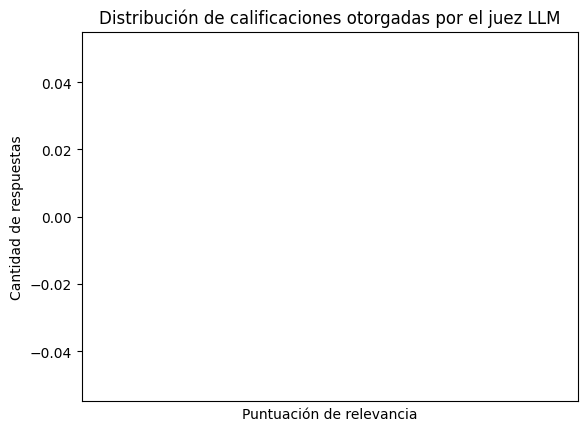

In [ ]:
import json
from collections import Counter

import matplotlib.pyplot as plt

# Leer las puntuaciones del archivo de evaluación
scores = []
with open("llm_judge_rag.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        eval_data = data.get("evaluation", {})
        score = eval_data.get("puntuacion_relevancia")
        # Si la puntuación es string, conviértela a int
        try:
            score_int = int(score)
            scores.append(score_int)
        except (TypeError, ValueError):
            continue  # Ignora líneas sin puntuación válida

# Contar la frecuencia de cada puntuación
score_counts = Counter(scores)
score_labels = sorted(score_counts.keys())
score_values = [score_counts[label] for label in score_labels]

# Graficar
plt.bar(score_labels, score_values, color='skyblue')
plt.xlabel("Puntuación de relevancia")
plt.ylabel("Cantidad de respuestas")
plt.title("Distribución de calificaciones otorgadas por el juez LLM")
plt.xticks(score_labels)
plt.show()